In [3]:
%pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install optuna


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [ ]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import KBinsDiscretizer
import shap
from sklearn.ensemble import RandomForestClassifier

#------------------------------------Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import joblib 



spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
pd.set_option('display.max_columns', 500)

#--------------------Model

import importlib
import modeling_utils
importlib.reload(modeling_utils) 
from eda_utils import calculate_psi, plot_distribution_plotly, calculate_woe_iv

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from modeling_utils import optimize_hyperparameters
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score,  brier_score_loss
import optuna
from modeling_utils import plot_model_evaluation_summary
from sklearn.calibration import calibration_curve, CalibrationDisplay, IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from modeling_utils import generate_classification_report



# Load data for modeling

In [7]:
df_model = pd.read_csv('df_total_woe.csv')


df_model.head(10)

,id,d_vintage,funded_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,addr_state,dti,fico_range_high,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,emp_length_numeric,term_numeric,emp_title_final_grouped,title_grouped,region_median_income,loan_to_income_ratio,revolving_balance_to_income_ratio,credit_utilization_manual,open_acc_ratio,set,target
0,68407277,2015-12-01,0.258841,-0.104389,-0.287373,0.160306,-0.086534,0.365801,-0.067006,0.403308,-0.217115,0.106942,-0.405376,0.024740,0.156173,-0.155903,-0.077618,-0.148191,-0.172215,-0.034501,-0.169441,-0.089716,0.084253,0.057010,0.310279,-0.020484,-0.007931,0.099562,0.457006,0.063355,0.023397,-0.007500,train,0.0
1,68355089,2015-12-01,-0.152670,0.229718,0.088483,0.160306,-0.030447,0.365801,-0.101768,0.107425,0.280817,0.106942,-0.405376,0.024740,-0.056093,0.630465,0.061496,-0.179923,-0.205649,0.238651,-0.252891,-0.260049,0.020176,0.057010,0.310279,0.172054,-0.081017,-0.075997,-0.478301,-0.066297,0.283653,-0.079388,train,0.0
2,68341763,2015-12-01,-0.152670,0.440679,0.355937,0.160306,-0.030447,0.365801,0.120678,0.282040,0.021937,-0.231529,-0.044784,-0.181297,0.378525,-0.139264,0.037777,0.025413,0.188066,0.238651,0.391569,0.047732,0.161126,0.057010,-0.721577,-0.313243,-0.081017,0.099562,-0.326559,0.111091,-0.045164,0.112083,train,0.0
3,68476807,2015-12-01,-0.052293,-1.109875,-1.167190,0.160306,0.262201,-0.078360,-0.067006,-0.164547,0.021937,-0.398292,-0.405376,-0.578527,0.378525,-0.075754,0.061496,-0.111674,-0.098426,0.350769,-0.169441,-0.260049,-0.044349,0.010116,-0.721577,-0.020484,-0.007931,-0.035045,0.387752,0.023428,-0.098688,0.112083,train,0.0
4,68426831,2015-12-01,-0.052293,-0.104389,-0.155127,-0.168686,-0.212208,-0.078360,0.094121,0.282040,-0.044342,-0.398292,-0.044784,0.456646,-0.176827,-0.194252,-0.392487,0.400004,0.495469,-0.189779,0.152740,0.000000,0.161126,0.010116,0.310279,-0.020484,-0.007931,0.054853,-0.478301,-0.032938,-0.127045,-0.226646,train,0.0
5,68476668,2015-12-01,-0.152670,0.736853,0.669339,0.160306,0.366531,0.365801,-0.014735,0.193799,-0.182636,-0.398292,-0.044784,-0.181297,0.378525,-0.347748,0.191351,0.001416,0.131069,0.238651,-0.076567,0.047732,-0.044349,0.057010,0.310279,0.012941,-0.007931,0.054853,0.387752,-0.141886,-0.339684,0.037363,train,0.0
6,67275481,2015-12-01,-0.152670,0.736853,0.769896,0.160306,0.072425,0.365801,0.255807,0.059621,0.123391,-0.231529,-0.044784,0.024740,0.109081,0.184215,-0.392487,0.400004,0.188066,0.169388,0.152740,0.047732,0.237851,0.057010,0.310279,-0.313243,-0.007931,-0.127956,-0.024098,0.043867,0.290291,-0.007500,train,0.0
7,68466926,2015-12-01,0.107043,1.752382,1.801500,-0.168686,0.072425,0.365801,-0.067006,0.193799,-0.084299,0.106942,-0.044784,-0.264431,-0.176827,0.040141,-0.077618,-0.283219,-0.285198,-0.034501,-0.169441,-0.260049,-0.215452,0.010116,0.310279,0.012941,-0.007931,-0.035045,0.360100,0.111091,0.087131,-0.079388,train,0.0
8,68616873,2015-12-01,0.206653,0.229718,0.239685,0.160306,-0.155503,0.365801,0.120678,-0.534175,0.123391,0.106942,-0.044784,-0.079886,0.378525,0.099580,0.137563,0.025413,0.131069,-0.034501,0.184122,0.047732,0.161126,0.057010,0.310279,-0.020484,-0.007931,-0.035045,0.168854,0.059959,0.187460,0.037363,train,0.0
9,68338832,2015-12-01,0.341164,0.055929,-0.039680,0.160306,-0.030447,0.365801,-0.059460,-0.534175,0.123391,-0.231529,-0.044784,0.024740,0.156173,0.040141,0.137563,0.119783,-0.205649,0.238651,0.069577,0.231346,-0.374405,0.010116,0.310279,-0.313243,-0.081017,-0.035045,0.586774,-0.141886,-0.098688,-0.181678,train,0.0


# Data Splitting 

In [8]:
X_train_i = df_model[df_model['set']=='train'].drop(['target', 'set'], axis=1).set_index(['id',	'd_vintage'])
y_train_i = df_model[df_model['set']=='train'].set_index(['id',	'd_vintage'])[['target']]


X_test = df_model[df_model['set']=='test'].drop(['target', 'set'], axis=1).set_index(['id',	'd_vintage'])
y_test = df_model[df_model['set']=='test'].set_index(['id',	'd_vintage'])[['target']]

print('Training data dimension', X_train_i.shape, y_train_i.shape)
print('Test data dimension', X_test.shape, y_test.shape)

Training data dimension (1004232, 30) (1004232, 1)
Test data dimension (343827, 30) (343827, 1)


# Training a Logistic Regession

### Assumptions


Assumptions of Logistic Regression
* Binary Dependent Variable:
Assumption: The target variable (target) must be binary (consisting of two categories).
Our Case: Met. Our target variable is 0 (no default) or 1 (default).


* Independence of Observations:
Assumption: The observations (each loan) must be independent of each other.
Our Case: Met. The Lending Club dataset consists of individual loans that do not influence one another, so this assumption is satisfied by the data collection design.


* Linearity in the Logit:
Assumption: There must be a linear relationship between each predictor variable and the log-odds of the target variable.
Our Case: Met, thanks to WoE! This is the primary reason why the Weight of Evidence (WoE) transformation is so powerful and standard in the industry. WoE is calculated as ln(distribution of non-events / distribution of events). By replacing the original categories with their WoE values, we are explicitly engineering a linear relationship with the log-odds of the target. You do not need to perform any additional tests for this; it is an inherent property of the transformation you have already applied.


* Absence of Perfect Multicollinearity:
Assumption: The predictor variables should not be perfectly correlated with each other. High multicollinearity (even if not perfect) can inflate the variance of the coefficients, making them unstable and difficult to interpret.
Our Case: This needs to be checked. Although your Mutual Information analysis helped eliminate redundancy among the original categorical variables, it is a best practice to check for multicollinearity in the final set of numerical (WoE-transformed) variables. The best way to do this is by calculating the Variance Inflation Factor (VIF).

In [130]:

print("Checking for multicollinearity in the training data using VIF...")


vif_df = modeling_utils.check_multicollinearity_vif(X_train_i)

Checking for multicollinearity in the training data using VIF...
Variance Inflation Factor (VIF) Analysis:
--------------------------------------------------
                              feature        VIF
0                           sub_grade  27.490839
1                            int_rate  26.158508
2                         funded_amnt   4.780430
3                loan_to_income_ratio   4.659414
4                          annual_inc   3.824285
5                      bc_open_to_buy   3.277507
6           credit_utilization_manual   2.981093
7               mo_sin_rcnt_rev_tl_op   2.833976
8                      mo_sin_rcnt_tl   2.303147
9                            mort_acc   2.066962
10                        avg_cur_bal   1.969094
11               mths_since_recent_bc   1.851410
12               acc_open_past_24mths   1.824716
13                    fico_range_high   1.812610
14                    num_actv_rev_tl   1.791447
15  revolving_balance_to_income_ratio   1.768194
16       

In [117]:
vif_df.head(50)

,feature,VIF
0,sub_grade,27.490839
1,int_rate,26.158508
2,funded_amnt,4.780430
3,loan_to_income_ratio,4.659414
4,annual_inc,3.824285
5,bc_open_to_buy,3.277507
6,credit_utilization_manual,2.981093
7,mo_sin_rcnt_rev_tl_op,2.833976
8,mo_sin_rcnt_tl,2.303147
9,mort_acc,2.066962


In [57]:

X_train_i_aux = X_train_i.drop(['sub_grade', 'int_rate', 'funded_amnt', 'term_numeric', 'verification_status', 'annual_inc'], axis=1)


df_to_correlate = X_train_i_aux.select_dtypes(include=['float64', 'int64'])


correlation_matrix = df_to_correlate.corr().abs()


correlation_pairs = correlation_matrix.unstack()


sorted_pairs = correlation_pairs.sort_values(ascending=False)

unique_correlation_pairs = sorted_pairs[sorted_pairs < 1].drop_duplicates()

print("Top 15 most correlated feature pairs:")
print(unique_correlation_pairs.head(15))


Top 15 most correlated feature pairs:
mo_sin_rcnt_tl         mo_sin_rcnt_rev_tl_op                0.701717
bc_open_to_buy         credit_utilization_manual            0.691929
mths_since_recent_bc   mo_sin_rcnt_rev_tl_op                0.637690
home_ownership         mort_acc                             0.571540
avg_cur_bal            mort_acc                             0.560675
mo_sin_rcnt_tl         acc_open_past_24mths                 0.530725
home_ownership         avg_cur_bal                          0.522794
mo_sin_rcnt_rev_tl_op  acc_open_past_24mths                 0.511735
bc_open_to_buy         fico_range_high                      0.500238
mo_sin_rcnt_tl         mths_since_recent_bc                 0.446201
mths_since_recent_bc   acc_open_past_24mths                 0.445578
fico_range_high        credit_utilization_manual            0.443583
inq_last_12m           all_util                             0.391957
open_acc_ratio         mort_acc                             0.366

### Dropping the feature and creating a calibrating set

In [9]:
X_train_i = X_train_i.drop(['sub_grade','credit_utilization_manual', 'revolving_balance_to_income_ratio', 'mo_sin_rcnt_rev_tl_op','int_rate', 'funded_amnt', 'term_numeric', 'verification_status', 'annual_inc'] , axis=1)

X_test = X_test.drop(['sub_grade', 'credit_utilization_manual', 'revolving_balance_to_income_ratio', 'mo_sin_rcnt_rev_tl_op', 'int_rate', 'funded_amnt', 'term_numeric', 'verification_status', 'annual_inc'], axis=1)


X_train, X_calib, y_train, y_calib = train_test_split(
    X_train_i, y_train_i,
    test_size=0.3,      
    random_state=42,
    stratify=y_train_i 
)

## Training LR

In [ ]:
def logistic_param_grid(trial):
    """
    Define the hyperparameter search space for Logistic Regression,
    including support for l1, l2, and elasticnet penalties.
    """
    
    # 1. Suggest a weight for the minority class (class 1)
    weight_for_one = trial.suggest_float('class_weight_one', 1.0, 50.0)
    
    # 2. Suggest the penalty type first, as it determines other parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    # 3. Define solver and other parameters based on the chosen penalty
    if penalty == 'elasticnet':
        solver = 'saga'  # 'elasticnet' is only supported by the 'saga' solver
        # The l1_ratio parameter is only used when penalty is 'elasticnet'
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        # 'liblinear' is a good choice for l1 and l2 as it's often faster for smaller datasets
        solver = 'liblinear'
        l1_ratio = None # Not used for l1/l2

    # 4. Construct the final hyperparameter grid
    param_grid = {
        'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
        'penalty': penalty,
        'solver': solver,
        'class_weight': {0: 1, 1: weight_for_one},
        'random_state': 42
    }

    # Add l1_ratio to the grid only if it's relevant
    if l1_ratio is not None:
        param_grid['l1_ratio'] = l1_ratio
        
    return param_grid

    

print("Initiating Logistic Regression optimization...")
best_logistic_params = optimize_hyperparameters(
    X=X_train, 
    y=y_train,
    model_class=LogisticRegression,
    param_grid=logistic_param_grid,
    n_trials=50  
)

### Evaluating the results

In [17]:
best_logistic_params = {
    'C': 0.0445,
    'penalty': 'l1',
    'solver': 'liblinear',
    'class_weight': {0: 1, 1: 1.445},  # Corregido a formato de diccionario
    'random_state': 42
}

final_logistic_model = LogisticRegression(**best_logistic_params)


y_train_flat = y_train.values.ravel()

final_logistic_model.fit(X_train, y_train_flat)

print("Final Logistic Regression model trained")


y_pred_train_proba = final_logistic_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = final_logistic_model.predict_proba(X_test)[:, 1]


auc_train = roc_auc_score(y_train.values.ravel(), y_pred_train_proba)
auc_test = roc_auc_score(y_test.values.ravel(), y_pred_test_proba)

print(f"\n--- Performance Outcomes ---")
print(f"AUC on the Training Set: {auc_train:.4f}")
print(f"AUC on the Test Set: {auc_test:.4f}")

# --- Comprobación de sobreajuste ---
overfitting_diff = auc_train - auc_test
print(f"Difference (Train - Test): {overfitting_diff:.4f}")
if overfitting_diff > 0.05:
    print("Warning: Possible overfitting. The difference between Train and Test is greater than 0.05.")
else:
    print("The model seems to generalize well. The difference is acceptable")

Final Logistic Regression model trained

--- Performance Outcomes ---
AUC on the Training Set: 0.6818
AUC on the Test Set: 0.6765
Difference (Train - Test): 0.0053
The model seems to generalize well. The difference is acceptable


In [10]:
X_train.columns

Index(['home_ownership', 'addr_state', 'dti', 'fico_range_high', 'all_util',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_rev_tl',
       'emp_length_numeric', 'emp_title_final_grouped', 'title_grouped',
       'region_median_income', 'loan_to_income_ratio', 'open_acc_ratio'],
      dtype='object')

### Feature Importance Analysis

/var/folders/v4/7dg4p38j5c31bxdhb2vhmmb00000gp/T/ipykernel_56971/139822414.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




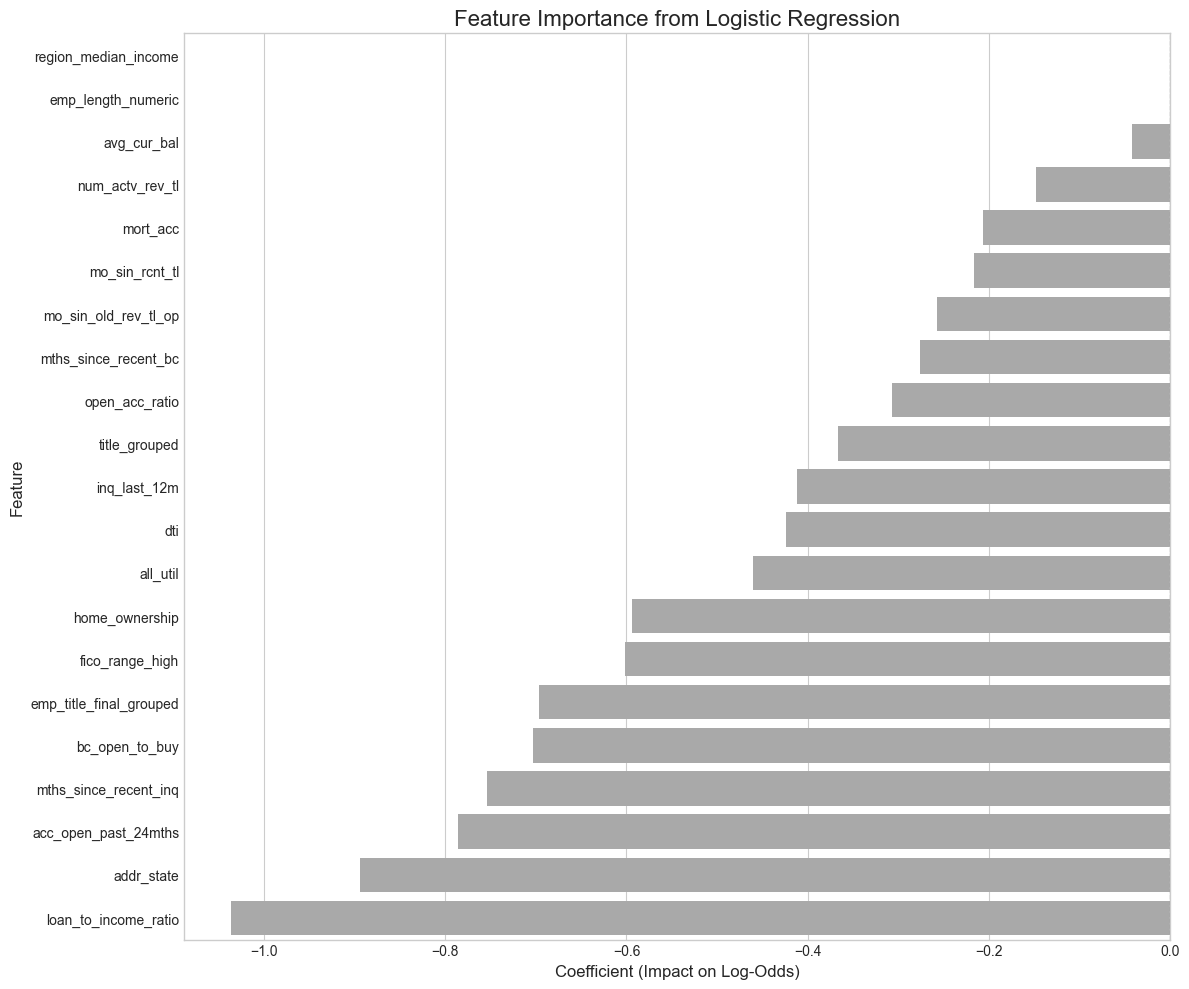

In [18]:

coefficients = final_logistic_model.coef_[0]
feature_names = X_train.columns


coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})


coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.style.use('seaborn-v0_8-whitegrid') 
fig, ax = plt.subplots(figsize=(12, 10)) 


colors = ['#9b59b6' if c > 0 else "#a9a9a9" for c in coef_df['Coefficient']]


sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=colors, ax=ax)


ax.axvline(0, color='black', linewidth=0.8, linestyle='--')


ax.set_title('Feature Importance from Logistic Regression', fontsize=16)
ax.set_xlabel('Coefficient (Impact on Log-Odds)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)


plt.tight_layout()
plt.show()




### Calibration

--- Getting probabilities on the calibration set ---
--- Training the isotonic calibrator ---
Calibrator trained.

--- Evaluating and visualizing on the Test set ---


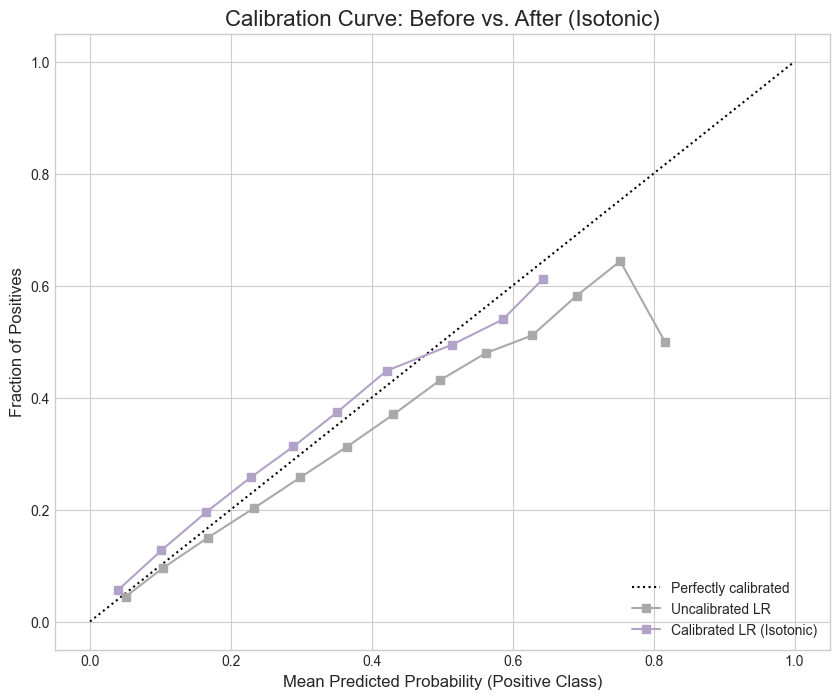


--- AUC Comparison on Test Set ---
AUC of uncalibrated model: 0.6765
AUC of calibrated model:    0.6764


In [19]:

colors = {
    "main_purple": "#b3a2c7",
    "medium_grey": "#a9a9a9"
}


print("--- Getting probabilities on the calibration set ---")
y_pred_calib_proba = final_logistic_model.predict_proba(X_calib)[:, 1]

print("--- Training the isotonic calibrator ---")

y_calib_flat = y_calib.values.ravel()
lr_isotonic_calibrator = IsotonicRegression(out_of_bounds='clip')
lr_isotonic_calibrator.fit(y_pred_calib_proba, y_calib_flat)
print("Calibrator trained.")

print("\n--- Evaluating and visualizing on the Test set ---")

y_pred_test_uncalibrated_proba = final_logistic_model.predict_proba(X_test)[:, 1]


y_pred_test_calibrated_proba = lr_isotonic_calibrator.transform(y_pred_test_uncalibrated_proba)


fig, ax = plt.subplots(figsize=(10, 8))


CalibrationDisplay.from_predictions(
    y_test,
    y_pred_test_uncalibrated_proba,
    n_bins=15,
    name='Uncalibrated LR',
    ax=ax,
    strategy='uniform',
    color=colors["medium_grey"]  
)

CalibrationDisplay.from_predictions(
    y_test,
    y_pred_test_calibrated_proba,
    n_bins=15,
    name='Calibrated LR (Isotonic)',
    ax=ax,
    strategy='uniform',
    color=colors["main_purple"]  
)


ax.set_title('Calibration Curve: Before vs. After (Isotonic)', fontsize=16)
ax.set_xlabel("Mean Predicted Probability (Positive Class)", fontsize=12)
ax.set_ylabel("Fraction of Positives", fontsize=12)
plt.show()


auc_test_uncalibrated = roc_auc_score(y_test, y_pred_test_uncalibrated_proba)
auc_test_calibrated = roc_auc_score(y_test, y_pred_test_calibrated_proba)

print(f"\n--- AUC Comparison on Test Set ---")
print(f"AUC of uncalibrated model: {auc_test_uncalibrated:.4f}")
print(f"AUC of calibrated model:    {auc_test_calibrated:.4f}")

## Results

### Setting threshold Precision-recall curve

In [20]:

uncalibrated_proba = final_logistic_model.predict_proba(X_calib)[:, 1]

y_pred_proba = lr_isotonic_calibrator.predict(uncalibrated_proba)


precisions, recalls, thresholds = precision_recall_curve(y_calib, y_pred_proba)


results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precisions[:-1],
    'Recall': recalls[:-1]
})

# Add F1-Score for a more balanced view
# Avoid division by zero if precision and recall are both 0
results_df['F1-Score'] = 2 * (results_df['Precision'] * results_df['Recall']) / \
                        (results_df['Precision'] + results_df['Recall']).replace(0, 1e-9)

print("--- Threshold Analysis Results ---")

display(results_df.sort_values(by='F1-Score', ascending=False).head(10))



fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['Precision'], name='Precision', line=dict(color='black')),
    secondary_y=False,
      
)
fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['Recall'], name='Recall', line=dict(color='#8e79a8')),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['F1-Score'], name='F1-Score', line=dict(dash='dot')),
    secondary_y=False,
)


best_f1_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_threshold = best_f1_row['Threshold']
best_f1_score = best_f1_row['F1-Score']

fig.add_vline(x=best_threshold, line_width=1, line_dash="dash", line_color="red",
              annotation_text=f'Best F1-Score Threshold: {best_threshold:.2f}',
              annotation_position="bottom right")


fig.update_layout(
    title_text='Precision, Recall, and F1-Score vs. Decision Threshold',
    xaxis_title='Decision Threshold',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white'
)

fig.show()

--- Threshold Analysis Results ---


,Threshold,Precision,Recall,F1-Score
60,0.203117,0.292265,0.619739,0.397209
59,0.194561,0.288937,0.634285,0.397019
61,0.217928,0.301643,0.578742,0.396585
58,0.187181,0.282431,0.662351,0.396004
57,0.185031,0.281401,0.666991,0.395811
62,0.219030,0.304567,0.564631,0.395694
56,0.181796,0.278443,0.680181,0.395132
55,0.176948,0.275422,0.693441,0.394253
63,0.226115,0.309685,0.541709,0.394081
64,0.228657,0.309946,0.540475,0.393965


In [21]:


def generate_classification_metrics(y_true, y_pred_proba, threshold, dataset_name="Test"):
    """
    Calculates a comprehensive set of classification metrics for a given threshold.
    This version includes debugging prints to diagnose issues.

    Args:
        y_true: True labels.
        y_pred_proba: Predicted probabilities for the positive class.
        threshold: The decision threshold to use.
        dataset_name: Name of the dataset ('Train' or 'Test') for printing.

    Returns:
        A dictionary containing all the calculated metrics.
    """
    # --- CRITICAL: Ensure alignment and correct data types ---
    y_true_np = np.asarray(y_true).astype(int)
    y_pred_proba_np = np.asarray(y_pred_proba).astype(float)
    
    # Apply the custom threshold
    y_pred = (y_pred_proba_np >= threshold).astype(int)
    
    # --- START DEBUGGING BLOCK ---
    print(f"\n--- Debugging Info for '{dataset_name}' Set ---")
    print(f"Threshold used: {threshold:.4f}")
    print(f"Shape of y_true_np: {y_true_np.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")
    print(f"Unique values in y_true_np: {np.unique(y_true_np)}")
    print(f"Unique values in y_pred: {np.unique(y_pred, return_counts=True)}")
    
    # Calculate and print the confusion matrix
    cm = confusion_matrix(y_true_np, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("---------------------------------------\n")
    # --- END DEBUGGING BLOCK ---

    # Now, calculate metrics as before
    report_dict = classification_report(y_true_np, y_pred, output_dict=True, zero_division=0)
    
    auc = roc_auc_score(y_true_np, y_pred_proba_np)
    gini = 2 * auc - 1
    brier = brier_score_loss(y_true_np, y_pred_proba_np)
    
    class_0_metrics = report_dict.get('0', {'precision': 0, 'recall': 0, 'f1-score': 0})
    class_1_metrics = report_dict.get('1', {'precision': 0, 'recall': 0, 'f1-score': 0})
    
    metrics = {
        "AUC": auc, "Gini": gini, "Brier Score": brier,
        "Precision (Class 0)": class_0_metrics['precision'],
        "Recall (Class 0)": class_0_metrics['recall'],
        "F1-Score (Class 0)": class_0_metrics['f1-score'],
        "Precision (Class 1)": class_1_metrics['precision'],
        "Recall (Class 1)": class_1_metrics['recall'],
        "F1-Score (Class 1)": class_1_metrics['f1-score'],
        "Accuracy": report_dict['accuracy']
    }
    
    return metrics


optimal_threshold = 0.19


test_uncalibrated_proba =  final_logistic_model.predict_proba(X_test)[:, 1]
test_pred_proba = lr_isotonic_calibrator.predict(test_uncalibrated_proba)

train_uncalibrated_proba =  final_logistic_model.predict_proba(X_train)[:, 1]
train_pred_proba = lr_isotonic_calibrator.predict(train_uncalibrated_proba)

test_metrics = generate_classification_metrics(y_test, test_pred_proba, optimal_threshold)


train_metrics = generate_classification_metrics(y_train, train_pred_proba, optimal_threshold, dataset_name="Train")
test_metrics = generate_classification_metrics(y_test, test_pred_proba, optimal_threshold, dataset_name="Test")





optimal_threshold_row = results_df.loc[results_df['F1-Score'].idxmax()]
optimal_threshold = optimal_threshold_row['Threshold']
print(f"Using Optimal Threshold (max F1-Score): {optimal_threshold:.4f}\n")




# --- STEP 3: Display the results in a clean comparison table ---
comparison_df = pd.DataFrame({
    'Train': train_metrics,

    'Test': test_metrics
})

print("--- Classification Metrics Comparison with Optimal Threshold ---")
display(comparison_df)


--- Debugging Info for 'Test' Set ---
Threshold used: 0.1900
Shape of y_true_np: (343827, 1)
Shape of y_pred: (343827,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([186695, 157132]))
Confusion Matrix:
[[159794 106518]
 [ 26901  50614]]
---------------------------------------


--- Debugging Info for 'Train' Set ---
Threshold used: 0.1900
Shape of y_true_np: (702962, 1)
Shape of y_pred: (702962,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([407739, 295223]))
Confusion Matrix:
[[358395 210304]
 [ 49344  84919]]
---------------------------------------


--- Debugging Info for 'Test' Set ---
Threshold used: 0.1900
Shape of y_true_np: (343827, 1)
Shape of y_pred: (343827,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([186695, 157132]))
Confusion Matrix:
[[159794 106518]
 [ 26901  50614]]
---------------------------------------

Using Optimal Threshold (max F1-Score): 0.2031

--- Cl

,Train,Test
AUC,0.681665,0.676446
Gini,0.363330,0.352892
Brier Score,0.144244,0.163344
Precision (Class 0),0.878981,0.855909
Recall (Class 0),0.630202,0.600026
F1-Score (Class 0),0.734087,0.705481
Precision (Class 1),0.287644,0.322111
Recall (Class 1),0.632483,0.652957
F1-Score (Class 1),0.395445,0.431405
Accuracy,0.630637,0.611959


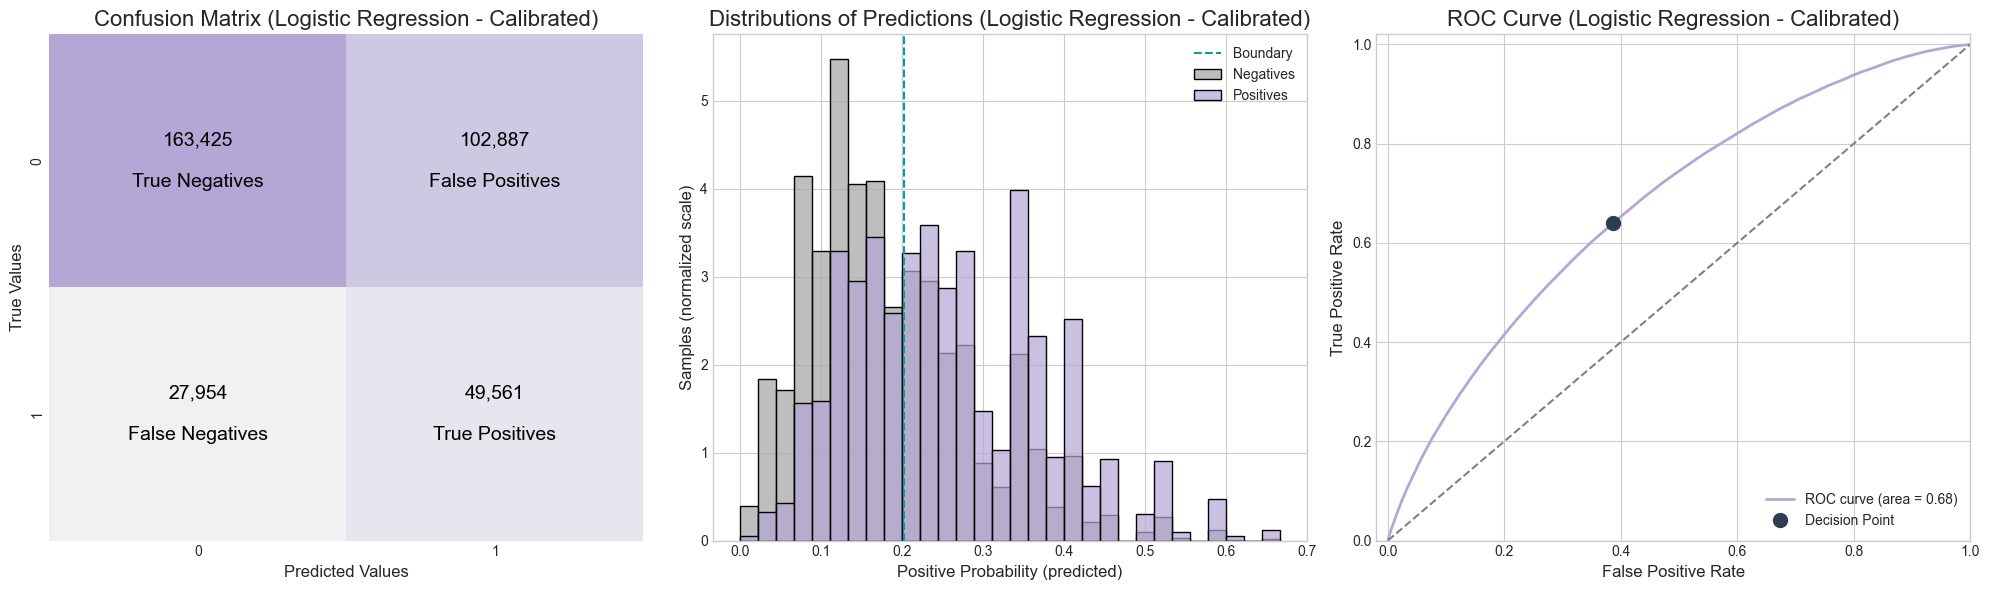

In [22]:
plot_model_evaluation_summary(
    base_model=final_logistic_model,              
    X_data=X_test,
    y_true=y_test.values.ravel(),
    calibrator=lr_isotonic_calibrator, 
    model_name='Logistic Regression',
    custom_color='#b4a7d6',
    threshold=optimal_threshold   
)

# Save model

In [23]:
joblib.dump(final_logistic_model, 'final_logistic_model_weights.joblib')

joblib.dump(lr_isotonic_calibrator, 'lr_isotonic_calibrator_weights.joblib')

['lr_isotonic_calibrator_weights.joblib']